# Classification, version 2, improvements like:                                                                                                      
                                                                                                                                   
  1. find_common_and_unique_routes() - Identifies matching and different routes between planned vs actual execution                               
    - Compares two route lists without using sets, analyzes route agreement between predictions and actuals                                                                                    
  2. get_positions() - Extracts location positions/indices from route sequences                                                                   
    - Creates position mapping for each location ID, enables detailed position analysis within routes                                                                                            
                                                                                                                                    
  3. Detailed prediction categorization - Expanded breakdown of model predictions                                                                 
                                                                      
  4. Model comparison framework - Side-by-side comparison of different models                                                                     
    - Analyzes which models correctly predict what                                                                                                
    - Identifies common failure patterns                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
  ---                                                                                                                                             
  Summary: V2 is a refinement of V1 with better route analysis tools (fix that metrics depends on order of the same locations and TW are included) and more granular prediction analysis, focusing on understanding where models succeed/fail rather than major architectural changes.

In [38]:
import pandas as pd
import numpy as np
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.cluster import KMeans

In [ ]:
data_stops = pd.read_csv('data/uni_molde_v3.csv', sep=';')

data_stops
data_stops.loc[data_stops['stop_completed_at'].isna(), 'stop_completed_at'] = "-1"
data_stops.loc[data_stops['stop_arrived_at'].isna(), 'stop_arrived_at'] = "-1"

print(data_stops.isnull().sum())


sorted_data_stops = data_stops.sort_values(by='stop_dispatched_at', ascending=True)
sorted_data_stops = sorted_data_stops.reset_index(drop=True)
sorted_data_stops['day_of_week'] = pd.to_datetime(sorted_data_stops['stop_dispatched_at']).dt.day_name()
sorted_data_stops['date'] = pd.to_datetime(sorted_data_stops['stop_dispatched_at']).dt.date

#clustering
locations_df = sorted_data_stops[['current_lat', 'current_lng']]
kmeans = KMeans(n_clusters=5000, random_state=42)
kmeans.fit(locations_df)
sorted_data_stops['cluster'] = kmeans.labels_ + 1

sorted_data_stops['location_id_craft'] = sorted_data_stops.groupby(['current_lat', 'current_lng']).ngroup()+1
with open('output.txt', 'w') as f:
    print(sorted_data_stops.to_string(), file=f)
print('number of groups', sorted_data_stops['location_id_craft'].nunique())

# data_stops_day= sorted_data_stops[sorted_data_stops['day_of_week'] == "Wednesday"]
grouped_df = sorted_data_stops.groupby('driver_workday_id')[['driver_id', 'location_type_id', 'address_id', 'location_id','stop_dispatched_at', 'stop_arrived_at', 'stop_earliest', 'stop_latest', 'current_lat', 'current_lng', 'stop_completed_at', 'cluster', 'location_id_craft','day_of_week', 'date', 'location_is_depot']].apply(lambda x: pd.Series({
    'driver_id': x['driver_id'].tolist(),
    'location_type_id': x['location_type_id'].tolist(),
    'planned_route_location': x['location_id'].tolist(),
    'stop_dispatched_at': x['stop_dispatched_at'].tolist(),
    'stop_arrived_at': x['stop_arrived_at'].tolist(),
    'stop_earliest': x['stop_earliest'].tolist(),
    'stop_latest': x['stop_latest'].tolist(),
    'current_lat': x['current_lat'].tolist(),
    'current_lng': x['current_lng'].tolist(),
    'stop_completed_at': x['stop_completed_at'].tolist(),
    'planned_route_cluster': x['cluster'].tolist(),
    'planned_route_craft': x['location_id_craft'].tolist(),
    'day_of_week': x['day_of_week'].tolist(),
    'location_is_depot': x['location_is_depot'].tolist(),
    'date': x['date'].tolist()
})).reset_index()
grouped_df
# grouped_df

In [ ]:
from geopy.distance import geodesic
import pandas as pd

# Function to calculate distance between two coordinates
def calculate_distance(row):
    distances = []
    for i in range(len(row['planned_route_craft'])-1):
        coords_1 = (sorted_data_stops.loc[sorted_data_stops['location_id_craft'] == row['planned_route_craft'][i], ['current_lat']].values[0][0],
                     sorted_data_stops.loc[sorted_data_stops['location_id_craft'] == row['planned_route_craft'][i], ['current_lng']].values[0][0])
        coords_2 = (sorted_data_stops.loc[sorted_data_stops['location_id_craft'] == row['planned_route_craft'][i+1], ['current_lat']].values[0][0],
                     sorted_data_stops.loc[sorted_data_stops['location_id_craft'] == row['planned_route_craft'][i+1], ['current_lng']].values[0][0])
        distances.append(geodesic(coords_1, coords_2).miles)
    return distances

def calculate_distance_actual(row):
    distances = []
    for i in range(len(row['actual_route_location'])-1):
        coords_1 = (sorted_data_stops.loc[sorted_data_stops['location_id_craft'] == row['actual_route_location'][i], ['current_lat']].values[0][0],
                     sorted_data_stops.loc[sorted_data_stops['location_id_craft'] == row['actual_route_location'][i], ['current_lng']].values[0][0])
        coords_2 = (sorted_data_stops.loc[sorted_data_stops['location_id_craft'] == row['actual_route_location'][i+1], ['current_lat']].values[0][0],
                     sorted_data_stops.loc[sorted_data_stops['location_id_craft'] == row['actual_route_location'][i+1], ['current_lng']].values[0][0])
        distances.append(geodesic(coords_1, coords_2).miles)
    return distances

# Create a new column 'distance_route' in 'final_routes'
grouped_df['distance_route'] = grouped_df.apply(calculate_distance, axis=1)
grouped_df['total_distance_planned'] = grouped_df['distance_route'].apply(sum)
# total_sum_distance = grouped_df['distance_route'].sum()
# grouped_df['total_distance'] = total_sum_distance

In [43]:
grouped_df['total_distance_planned'] = grouped_df['distance_route'].apply(sum)
routes = grouped_df[grouped_df.apply(lambda row: max(row['stop_dispatched_at']) < min(row['stop_completed_at']), axis=1)]
routes = routes.reset_index(drop=True)
len(routes)

20692

In [ ]:
index_routes_with_na = []
for i in range(len(routes)):
    row = routes.iloc[i]
    if "-1" in row['stop_arrived_at']:
        index_routes_with_na.append(i)
print("The number of routes where one value is NA(arrived time)", len(index_routes_with_na))
print(index_routes_with_na)
routes = routes.drop(index_routes_with_na)
routes.reset_index(drop=True)
#
print(len(routes))

In [45]:
#check if it is the same driver in the route
routes['day_of_week'] = routes['stop_arrived_at'].apply(lambda x: [pd.to_datetime(dt).day_name() for dt in x])

def get_mode(x):
    return pd.Series(x).mode().iloc[0] if not pd.Series(x).mode().empty else np.nan

for i in routes['driver_id']:
    if not all(x == i[0] for x in i):
            print('Not the same driver in the route')
routes['driver_id'] = routes['driver_id'].apply(lambda x : x[0])

routes['day_of_week'] = routes['day_of_week'].apply(get_mode)
routes['date'] = routes['date'].apply(get_mode)

routes['date'] = pd.to_datetime(routes['date'])
routes['last_two_weeks_count'] = routes.apply(lambda row:
                                      routes[(routes['driver_id'] == row['driver_id']) &
                                         (row['date'] - routes['date']).dt.days.between(-14, 0)].shape[0],
                                      axis=1)
routes = routes[(routes['date'] < '2023-12-21') | (routes['date'] > '2024-01-14')]
routes['location_type_id'] = routes['location_type_id'].apply(lambda x: [0 if i == 1 else 1 for i in x])
routes['location_is_depot'] = routes['location_is_depot'].apply(lambda x: [int(value) for value in x])

routes = routes[routes['planned_route_craft'].apply(lambda x: len(x) > 2)]
routes = routes.reset_index(drop=True)

In [47]:
def create_actual_route(df, column):
    res_col = []
    for i in range(len(df)):
        row = df.iloc[i]
        sorted_dates = sorted(row['stop_arrived_at'])
        mapping = {}
        for i, date in enumerate(row['stop_arrived_at']):
            mapping[date] = row[column][i]
        res_val = [mapping[sorted_dates[i]] for i in range(len(sorted_dates))]
        res_col.append(res_val)
    return res_col

def create_actual_route_type(df, column):
    res_col = []
    for i in range(len(df)):
        row = df.iloc[i]
        sorted_dates = sorted(row['stop_arrived_at'])
        mapping = {}
        for i, date in enumerate(row['stop_arrived_at']):
            mapping[date] = row['location_type_id'][i]
        res_val = [mapping[sorted_dates[i]] for i in range(len(sorted_dates))]
        res_col.append(res_val)
    return res_col

routes['actual_route_location'] = create_actual_route(routes, 'planned_route_craft')
routes['actual_route_type'] = create_actual_route_type(routes, 'planned_route_craft')
routes['distance_actual_route'] = routes.apply(calculate_distance_actual, axis=1)
routes['total_distance_actual'] = routes['distance_actual_route'].apply(sum)
routes['difference_distance'] = (routes['total_distance_actual'] - routes['total_distance_planned'])/routes['total_distance_planned']

#remove all the routes with length <= 2
routes = routes[routes['planned_route_craft'].apply(lambda x: len(x) > 2)]
routes = routes.reset_index(drop=True)

len(routes)

18562

In [48]:
routes = routes.reset_index(drop=True)
more_than_one_1 = routes[routes['location_is_depot'].apply(lambda x: x.count(True) > 1)]
len(more_than_one_1), len(routes)

routes['actual_route_unique'] = create_actual_route(routes, 'planned_route_location')

In [49]:
planned_routes = routes[['planned_route_craft', 'actual_route_location', 'driver_id', 'day_of_week', 'last_two_weeks_count', 'location_type_id', 'stop_arrived_at', 'stop_earliest', 'stop_latest', 'current_lat', 'current_lng', 'difference_distance', 'distance_route', 'distance_actual_route', 'location_is_depot', 'location_type_id', 'date', 'planned_route_location', 'actual_route_unique']]
actual_routes = routes['actual_route_location']

In [51]:
planned_routes_list = planned_routes['planned_route_craft'].tolist()
actual_routes_list = actual_routes.tolist()

# filtered_rows = []
#
# for row in actual_routes_list:
#     if row not in planned_routes_list:
#         filtered_rows.append(row)

#duplicated removed
# planned_routes_list = [array for i, array in enumerate(planned_routes_list) if array not in planned_routes_list[:i]]
# actual_routes_list = [array for i, array in enumerate(filtered_rows) if array not in filtered_rows[:i]]
len(planned_routes_list),len(actual_routes_list)

(18562, 18562)

# Edit distance

In [ ]:
# Edit Distance

def minDistance(word1, word2) -> int:
    m = len(word1)
    n = len(word2)
    # dp[i][j] := min # Of operations to convert word1[0..i) to word2[0..j)
    dp = [[0] * (n + 1) for _ in range(m + 1)]

    for i in range(1, m + 1):
      dp[i][0] = i

    for j in range(1, n + 1):
      dp[0][j] = j

    for i in range(1, m + 1):
      for j in range(1, n + 1):
        if word1[i - 1] == word2[j - 1]:
          dp[i][j] = dp[i - 1][j - 1]
        else:
          dp[i][j] = min(dp[i - 1][j - 1], dp[i - 1][j], dp[i][j - 1]) + 1

    return dp[m][n]


# Route quality score

In [ ]:
def calculate_route_quality_score(planned_ranks, actual_ranks):
    # Calculate sum of absolute differences in ranks
    sum_of_differences = sum(abs(actual_ranks.index(x) - planned_ranks.index(x)) for x in planned_ranks)

    # Calculate max possible difference
    max_possible_difference = sum([abs(2 * i - (len(planned_ranks) + 1)) for i in range(1, len(planned_ranks) + 1)])

    # Calculate route quality score
    route_quality_score = 1 - (sum_of_differences / max_possible_difference)
    return route_quality_score

    # return route_quality_score



In [ ]:
from collections import defaultdict
def get_positions(seq):
    d = defaultdict(lambda: [])
    for idx, item in enumerate(seq):
        d[item].append(idx)
    return d

def calculate_route_quality_score(planned_ranks, actual_ranks):
    sum_of_differences = 0
    planned = get_positions(planned_ranks)
    actual = get_positions(actual_ranks)
    for key in planned:
        for i in range(len(planned[key])):
            sum_of_differences += abs(planned[key][i] - actual[key][i])
    max_possible_difference = sum([abs(2 * i - (len(planned_ranks) + 1)) for i in range(1, len(planned_ranks) + 1)])

    # Calculate route quality score
    route_quality_score = 1 - (sum_of_differences / max_possible_difference)
    return route_quality_score


For each driver-day, we consider only the planned route. For each planned route we calculate how much it deviates from the actual route (e.g., use some form of edit distance - see https://link.springer.com/article/10.1007/s10732-006-9001-3?), which is then normalized (divide by edit distance, or number of visits or something?) to the interval [0, 1]. Then, a planned route is good if this distance (between planned and actual) is less than a certain threshold and otherwise it is bad. This becomes the label (bad/good)

In [ ]:
import statistics
completed_routes_df = pd.DataFrame(columns=['planned_route_craft', 'actual_route_location', 'driver_id', 'day_of_week', 'distance_route', 'distance_actual_route', 'last_two_weeks_count', 'stop_arrived_at', 'stop_earliest', 'stop_latest', 'current_lat', 'current_lng', 'location_type_id', 'location_is_depot', 'date'])
uncompleted_routes_df = pd.DataFrame(columns=['planned_route_craft', 'actual_route_location', 'driver_id', 'day_of_week', 'distance_route', 'distance_actual_route', 'last_two_weeks_count', 'stop_arrived_at', 'stop_earliest', 'stop_latest', 'current_lat', 'current_lng', 'location_type_id', 'location_is_depot', 'date'])
#11700795
scores = []
edit_distances = []
completed_routes_list = []
uncompleted_routes_list = []
for i in range(len(planned_routes_list)):
    editDistance = minDistance(planned_routes_list[i], actual_routes_list[i]) / len(planned_routes_list[i])
    score = calculate_route_quality_score(planned_routes_list[i], actual_routes_list[i])
    scores.append(score)
    edit_distances.append(editDistance)

    #if score >= 0.85 and editDistance <= 0.3 and planned_routes['difference_distance'].iloc[i] <= 0.03: main
    # if editDistance > 0.05 and score < 0.95 and planned_routes['difference_distance'].iloc[i] > 0.01:

    # if editDistance <= 0 and score >= 1 and planned_routes['difference_distance'].iloc[i] <= 0:
    if score >= 0.85 and editDistance <= 0.3 and planned_routes['difference_distance'].iloc[i] <= 0.03:
        completed_routes_list.append(planned_routes.iloc[i].to_dict())
    else:
        uncompleted_routes_list.append(planned_routes.iloc[i].to_dict())

# Convert the lists to DataFrames
completed_routes_df = pd.DataFrame(completed_routes_list)
uncompleted_routes_df = pd.DataFrame(uncompleted_routes_list)

print(len(completed_routes_df), len(uncompleted_routes_df))
completed_routes_df


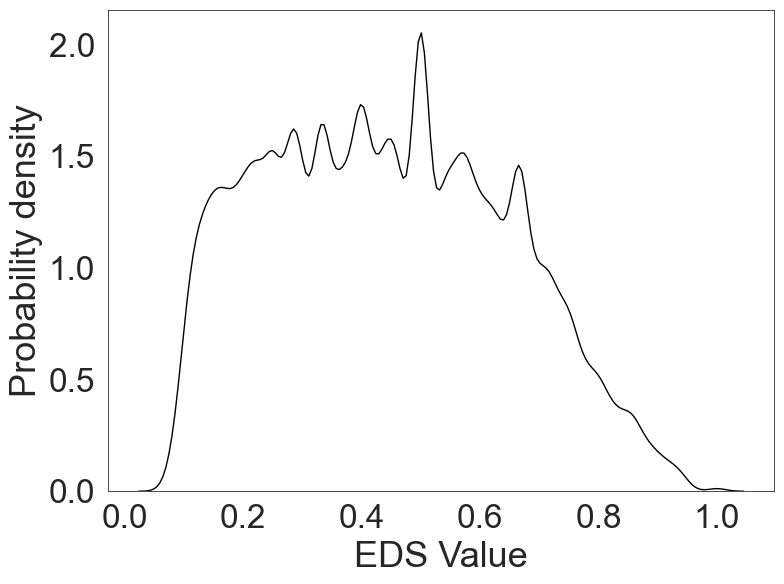

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

scores = [v for v in edit_distances if v != 0]
# edit_distances = pd.DataFrame(scores, columns=['Edit Distances'])
# edit_distances.describe()
# distances_without_outl = routes[(routes['difference_distance'] < 2) & (routes['difference_distance'] > 0)]['difference_distance']

# print(distances_without_outl)

sns.set(style='white')
plt.figure(figsize=(8, 6))

sns.kdeplot(data=scores, color='black', linewidth=1, fill=False, bw_adjust=0.5)

plt.xlabel('EDS Value', fontsize=26)
plt.ylabel('Probability density', fontsize=26)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.tick_params(axis='both', which='minor', labelsize=24)

# plt.xlim(-0.1, 2)

ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(0.5)

plt.tight_layout()
plt.grid(False)
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

scores = [v for v in scores if v != 1]
scores = pd.DataFrame(scores, columns=['Score'])
# # scores.describe()
#
# edit_distances = [v for v in edit_distances if v != 0]
# edit_distances = pd.DataFrame(edit_distances, columns=['Edit Distances'])
# edit_distances.describe()

# routes[routes['difference_distance'] > 0]['difference_distance'].describe()


# Set style and context for publication-ready figures
sns.set(style='white')

# Create a larger figure
plt.figure(figsize=(8, 6))
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'green_amber_red', [(0, 'green'), (0.1, 'yellow'), (0.4, 'orange'), (1, 'red')]
)

# Normalize the data for color mapping
norm = mpl.colors.Normalize(vmin=0, vmax=2)

# Calculate the KDE
kde = sns.kdeplot(scores, fill=False, bw_adjust=0.5)
x, y = kde.get_lines()[0].get_data()

# Clear the plot to redraw with gradient
plt.clf()

# Set style and context for publication-ready figures
sns.set(style='white')

# Create a larger figure
plt.figure(figsize=(8, 6))

# Plot with gradient color
# for i in range(len(x) - 1):
#     plt.plot(x[i:i+2], y[i:i+2], color=cmap(norm(np.mean(x[i:i+2]))), linewidth=2)

# Add titles and labels
plt.xlabel('DDS', fontsize=26)
plt.ylabel('Probability density', fontsize=20)

plt.tick_params(axis='both', which='major', labelsize=20)  # Major ticks
plt.tick_params(axis='both', which='minor', labelsize=20)  # Minor ticks (if any)

ax = plt.gca()  # Get the current axes
for spine in ax.spines.values():
    spine.set_edgecolor('black')  # Color of the border
    spine.set_linewidth(0.5)  # Thickness of the border

plt.tight_layout()
plt.grid(False)  # Remove gridlines

# Display the plot
plt.show()


In [ ]:
drivers_dic = {}
k = 1
for driver in completed_routes_df['driver_id']:
    if driver not in drivers_dic:
        drivers_dic[driver] = k
        k += 1
print('Total number of drivers', len(drivers_dic))
total_drivers = len(drivers_dic)
encoding_drivers = []
for driver in completed_routes_df['driver_id']:
    encoding_drivers.append(drivers_dic[driver])
#
completed_routes_df['driver_id_sorted'] = encoding_drivers
# final_routes = pd.concat([final_routes, pd.get_dummies(final_routes['driver_id_sorted'], prefix='encoding_drivers')], axis=1)
completed_routes_df

In [25]:
sunday_count = completed_routes_df[completed_routes_df["day_of_week"] == "Sunday"].shape[0]
print(f"Number of rows on Sunday: {sunday_count}")

Number of rows on Sunday: 22


In [ ]:
final_routes = pd.DataFrame({
    'routes': completed_routes_df['planned_route_craft'].tolist() + uncompleted_routes_df['planned_route_craft'].tolist(),
    'actual_routes': completed_routes_df['actual_route_location'].tolist() + uncompleted_routes_df['actual_route_location'].tolist(),
    'driver_id': completed_routes_df['driver_id'].tolist() +  uncompleted_routes_df['driver_id'].tolist(),
    'distance_route': completed_routes_df['distance_route'].tolist() + uncompleted_routes_df['distance_route'].tolist(),
    'distance_actual_route': completed_routes_df['distance_actual_route'].tolist() + uncompleted_routes_df['distance_actual_route'].tolist(),
    'last_two_weeks_count': completed_routes_df['last_two_weeks_count'].tolist() + uncompleted_routes_df['last_two_weeks_count'].tolist(),
    'current_lat': completed_routes_df['current_lat'].tolist() + uncompleted_routes_df['current_lat'].tolist(),
    'current_lng': completed_routes_df['current_lng'].tolist() + uncompleted_routes_df['current_lng'].tolist(),
    'day_of_week': completed_routes_df['day_of_week'].tolist() + uncompleted_routes_df['day_of_week'].tolist(),
    'date': completed_routes_df['date'].tolist() + uncompleted_routes_df['date'].tolist(),
    'location_is_depot': completed_routes_df['location_is_depot'].tolist() + uncompleted_routes_df['location_is_depot'].tolist(),
    'location_type_id': completed_routes_df['location_type_id'].tolist() + uncompleted_routes_df['location_type_id'].tolist(),
    'arriving_time': completed_routes_df['stop_arrived_at'].tolist() + uncompleted_routes_df['stop_arrived_at'].tolist(),
    'label': [0] * len(completed_routes_df)  + [1] * len(uncompleted_routes_df)
})
final_routes['len'] = final_routes['routes'].apply(lambda x: len(x))
final_routes

# [0] * len(artificial_planned_routes)
# artificial_planned_routes['distance_route'].tolist()
# artificial_planned_routes['driver_id'].tolist()
# artificial_planned_routes['common_subsequence'].tolist()

In [28]:
def determine_country(lat, lng):
    if 57.5 <= lat <= 71.2 and 4.0 <= lng <= 31.0:
        return 0  # Norway
    elif 54.5 <= lat <= 57.8 and 8.0 <= lng <= 15.0:
        return 1  # Denmark
    else:
        return 1
final_routes['country_flag'] = final_routes.apply(lambda row: determine_country(row['current_lat'][0], row['current_lng'][0]), axis=1)

max([len(i) for i in final_routes['routes']])

36

In [30]:
#create dictionary and encode to smaller unique numbers
locations_dic = {}
location_count = {}
k = 1
for row in final_routes['routes']:
   for location in row:
       if location not in locations_dic:
           locations_dic[location] = k
           k += 1
k = 1
print(len(locations_dic))

for row in final_routes['routes']:
   for location in row:
       if location not in location_count:
            location_count[location] = 1
       else:
            location_count[location] += 1


10704


In [31]:
drivers_dic = {}
k = 1
for driver in final_routes['driver_id']:
    if driver not in drivers_dic:
        drivers_dic[driver] = k
        k += 1
print('Total number of drivers', len(drivers_dic))
total_drivers = len(drivers_dic)
encoding_drivers = []
for driver in final_routes['driver_id']:
    encoding_drivers.append(drivers_dic[driver])
#
final_routes['driver_id_sorted'] = encoding_drivers
final_routes['day_of_week_encoded'] = pd.Categorical(final_routes['day_of_week']).codes+1

def encode_day_of_week(row):
    a = np.zeros((36, 7), dtype=int)
    route_len = row['len']
    day_encoded = row['day_of_week_encoded']
    for i in range(36 - route_len, len(a)):
        a[i][day_encoded-1] = 1
    return a

def encode_day_of_week_simple(row):
    a = np.zeros(7, dtype=int)
    day_encoded = row['day_of_week_encoded']
    a[day_encoded - 1] = 1
    return a

final_routes['experience_feature'] = final_routes.apply(lambda x: x['len'] * [x['last_two_weeks_count']], axis = 1)
final_routes['len_feature'] = final_routes.apply(lambda x: x['len'] * [x['len']], axis = 1)
final_routes['driver_id_feature'] = final_routes.apply(lambda x: x['len'] * [x['driver_id_sorted']], axis = 1)
final_routes['country_flag_feature'] = final_routes.apply(lambda x: x['len'] * [x['country_flag']], axis = 1)
final_routes['day_of_week_feature'] = final_routes.apply(encode_day_of_week, axis = 1)
final_routes['day_of_week_encoded_ext'] = final_routes.apply(encode_day_of_week_simple, axis = 1)

# encoding_routes = []
# for row in final_routes['routes']:
#     encoding_route = []
#     for location in row:
#         encoding_route.append(locations_dic[location])
#     encoding_routes.append(encoding_route)
# final_routes['routes'] = encoding_routes

print('correlation', final_routes['len'].corr(final_routes['label']))
print('correlation', max(final_routes['len']))
# final_routes = pd.concat([final_routes, pd.get_dummies(final_routes['driver_id_sorted'], prefix='encoding_drivers')], axis=1)

Total number of drivers 395
correlation 0.31512808794486846
correlation 36


In [ ]:
final_routes['first_arrival'] = final_routes['arriving_time'].apply(lambda x: x[0])

# Convert to datetime and sort
final_routes['first_arrival'] = pd.to_datetime(final_routes['first_arrival'])
final_routes = final_routes.sort_values('first_arrival').reset_index(drop=True)

# Drop the temporary column
final_routes = final_routes.drop('first_arrival', axis=1)
final_routes

In [ ]:


final_routes['score_cumulative_avg'] = final_routes.groupby(['driver_id_sorted', 'day_of_week'])['label'].transform(
        lambda x: x.expanding().mean()
    )
final_routes['score_cumulative_driver'] = final_routes.groupby(['driver_id_sorted'])['label'].transform(
        lambda x: x.expanding().mean()
    )
final_routes['score_avg_total'] = final_routes['label'].expanding().mean()

final_routes

# Average benchmark 

In [36]:
# result = final_routes.groupby('driver_id_sorted')[['driver_id_sorted', 'score']].apply(
#     lambda x: pd.Series({'count': len(x), 'score': x['score'].tolist()})
# ).reset_index()
#
# sorted_result = result.sort_values(by='count', ascending=False).reset_index(drop=True)


In [37]:
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, log_loss, brier_score_loss
)
import matplotlib.pyplot as plt

def get_predictions(df, scores_dict):
    def predict(row):
        # Try to get the score from the main dictionary
        label = scores_dict.get((row['driver_id_sorted'], row['day_of_week']))
        return label
        # If not found, fall back to the driver-only dictionary
        # if label is None:
        #     print('1')
        #     return 0.5
        # else:
        #     return label

    return df.apply(predict, axis=1)


# Function to calculate metrics
def calculate_metrics(y_true, y_pred, y_pred_proba):
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    average_precision = average_precision_score(y_true, y_pred)
    quadratic_loss = log_loss(y_true, y_pred_proba)
    brier_score = brier_score_loss(y_true, y_pred_proba)

    metrics = {
        "acc": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc,
        "average_precision": average_precision,
        "quadratic_loss": quadratic_loss,
        "brier_score": brier_score,
    }
    return metrics

In [51]:
from sklearn.metrics import confusion_matrix
def get_predictions(df, scores_dict):
    def predict(row):
        # Try to get the score from the main dictionary
        label = scores_dict.get((row['driver_id_sorted'], row['day_of_week']))

        # If not found, fall back to the driver-only dictionary
        if label is None:
            print('1')
            return 0.5
        else:
            return label

    return df.apply(predict, axis=1)
def calculate_metrics(y_true, y_pred, y_pred_proba):
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    average_precision = average_precision_score(y_true, y_pred)
    quadratic_loss = log_loss(y_true, y_pred_proba)
    brier_score = brier_score_loss(y_true, y_pred_proba)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    metrics = {
        "acc": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc,
        "average_precision": average_precision,
        "quadratic_loss": quadratic_loss,
        "brier_score": brier_score,
        "true_positive": tp,
        "false_positive": fp,
        "true_negative": tn,
        "false_negative": fn
    }
    return metrics

def split_group(group):
    n = len(group)
    if n < 4:  # Ensure at least 1 sample for train and 1 each for val and test
        return pd.DataFrame()

    # Calculate sizes for each split
    train_size = max(int(n * 0.8), n - 4)  # Ensure at least 2 samples total for val and test
    val_test_size = n - train_size

    # Always give the extra sample to val when odd
    val_size = (val_test_size + 1) // 2  # This will be larger when val_test_size is odd
    test_size = val_test_size - val_size

    return pd.concat([
        group.iloc[:train_size].assign(split='train'),
        group.iloc[train_size:train_size+val_size].assign(split='val'),
        group.iloc[train_size+val_size:].assign(split='test')
    ])

def categorize_predictions(df, y_true, y_pred, y_pred_proba):
    df = df.copy()
    df['prediction_category'] = 'Unknown'
    df.loc[(y_true == 1) & (y_pred == 1), 'prediction_category'] = 'True Positive'
    df.loc[(y_true == 0) & (y_pred == 1), 'prediction_category'] = 'False Positive'
    df.loc[(y_true == 1) & (y_pred == 0), 'prediction_category'] = 'False Negative'
    df.loc[(y_true == 0) & (y_pred == 0), 'prediction_category'] = 'True Negative'
    df['predictive_probability'] = y_pred_proba
    return df

def save_categorized_routes(df, filename):
    df.to_csv(filename, index=False)
    print(f"Saved categorized routes to {filename}")


final_routes_split = final_routes.groupby(['driver_id_sorted', 'day_of_week']).apply(split_group).reset_index(drop=True)
# Separate into train, validation, and test sets

drivers_dic = {}
k = 1
for driver in final_routes_split['driver_id_sorted']:
    if driver not in drivers_dic:
        drivers_dic[driver] = k
        k += 1
print('Total number of drivers', len(drivers_dic))
total_drivers = len(drivers_dic)
encoding_drivers = []
for driver in final_routes_split['driver_id_sorted']:
    encoding_drivers.append(drivers_dic[driver])
#
final_routes_split['driver_id_sorted'] = encoding_drivers

locations_dic = {}
location_count = {}
k = 1
for row in final_routes_split['routes']:
   for location in row:
       if location not in locations_dic:
           locations_dic[location] = k
           k += 1
k = 1
print(len(locations_dic))

for row in final_routes_split['routes']:
   for location in row:
       if location not in location_count:
            location_count[location] = 1
       else:
            location_count[location] += 1
encoding_routes = []
for row in final_routes_split['routes']:
    encoding_route = []
    for location in row:
        encoding_route.append(locations_dic[location])
    encoding_routes.append(encoding_route)
final_routes_split['routes'] = encoding_routes

print(len(final_routes_split))
train_df = final_routes_split[final_routes_split['split'] == 'train'].drop('split', axis=1)
val_df = final_routes_split[final_routes_split['split'] == 'val'].drop('split', axis=1)
test_df = final_routes_split[final_routes_split['split'] == 'test'].drop('split', axis=1)

print('lens', len(train_df), len(val_df), len(test_df))
combined_df = pd.concat([train_df, val_df, test_df], axis=0)
combined_df = combined_df.reset_index(drop=True)

val_y_true = val_df['label']
average_scores_dict = train_df.groupby(['driver_id_sorted', 'day_of_week'])['score_cumulative_avg'].last().to_dict()
average_scores_dict_driver = train_df.groupby(['driver_id_sorted'])['score_cumulative_driver'].last().to_dict()
total_avg = train_df['score_avg_total'].iloc[-1]
val_y_pred_proba = get_predictions(val_df, average_scores_dict)
val_y_pred = (val_y_pred_proba.values > 0.5).astype(int)
val_metrics = calculate_metrics(val_y_true, val_y_pred, val_y_pred_proba)

# # # Calculate metrics for test set
test_y_true = test_df['label']
test_y_pred_proba = get_predictions(test_df, average_scores_dict)
test_y_pred = (test_y_pred_proba.values > 0.5).astype(int)
test_metrics = calculate_metrics(test_y_true, test_y_pred, test_y_pred_proba)

# test_y_pred_proba = pd.Series([total_avg] * len(test_y_true))
# test_y_pred = (test_y_pred_proba > 0.5).astype(int)
# test_metrics = calculate_metrics(test_y_true, test_y_pred, test_y_pred_proba)

print('val_metrics', val_metrics)
print('test_metrics', test_metrics)

test_df_group_HA = categorize_predictions(test_df, test_y_true, test_y_pred, test_y_pred_proba)
# save_categorized_routes(test_df_categorized, 'test_routes_categorized_HA.csv')
test_df_group_HA[test_df_group_HA['prediction_category'] == 'True Positive']['routes']
print(len(test_df_group_HA[test_df_group_HA['prediction_category'] == 'True Positive']['routes']), len(test_df_group_HA[test_df_group_HA['prediction_category'] == 'False Positive']['routes']))

/var/folders/0j/mpbqwzf51p38zw2w423xp1fw0000gn/T/ipykernel_18931/1217222917.py:76: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  final_routes_split = final_routes.groupby(['driver_id_sorted', 'day_of_week']).apply(split_group).reset_index(drop=True)


Total number of drivers 314
10546
17667
lens 13823 2188 1656
val_metrics {'acc': 0.7143510054844607, 'precision': 0.7315541601255887, 'recall': 0.7670781893004115, 'f1': 0.7488951386098834, 'roc_auc': 0.7077939764590444, 'average_precision': 0.6905011052409561, 'quadratic_loss': 1.2720613746590246, 'brier_score': 0.19390942165158653, 'true_positive': 932, 'false_positive': 342, 'true_negative': 631, 'false_negative': 283}
test_metrics {'acc': 0.7065217391304348, 'precision': 0.7199170124481328, 'recall': 0.7626373626373626, 'f1': 0.7406616862326574, 'roc_auc': 0.7003535338655982, 'average_precision': 0.679470394299909, 'quadratic_loss': 1.2956978793104297, 'brier_score': 0.19880618428965857, 'true_positive': 694, 'false_positive': 270, 'true_negative': 476, 'false_negative': 216}
694 270


# After benchmark, continue model

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming final_routes dataframe is available and sorted by date
# If not, make sure to sort it by date first

# Prepare the data
rf_df = final_routes_split[['driver_id_sorted', 'day_of_week_encoded', 'label', 'split', 'routes']]
o_day_of = pd.get_dummies(rf_df['day_of_week_encoded'], prefix='day')
o_driver = pd.get_dummies(rf_df['driver_id_sorted'], prefix='driver')
rf_df = pd.concat([o_day_of, o_driver, rf_df['split'], rf_df['label'], rf_df['routes']], axis=1)


for col in rf_df.columns:
    if col != 'split' and col != 'label' and col != 'routes':
        rf_df[col] = rf_df[col].astype(int)

train_df = rf_df[rf_df['split'] == 'train'].drop('split', axis=1)
val_df = rf_df[rf_df['split'] == 'val'].drop('split', axis=1)
test_df = rf_df[rf_df['split'] == 'test'].drop('split', axis=1)

# Create X_train and y_train
X_train = train_df.drop('label', axis=1)
y_train = train_df['label']

# Create X_val and y_val (optional, but often useful)
X_val = val_df.drop('label', axis=1)
y_val = val_df['label']

# Create X_test and y_test (optional, but often useful)
X_test = test_df.drop('label', axis=1)
y_test = test_df['label']

print(len(train_df), len(val_df), len(test_df))
#
#
# Train the model
model = RandomForestRegressor(random_state=42)
X_trainwr = X_train.drop('routes', axis=1)
model.fit(X_trainwr, y_train)

# Function to calculate metrics
def calculate_metrics(y_true, y_pred, y_pred_proba):
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    average_precision = average_precision_score(y_true, y_pred)
    quadratic_loss = log_loss(y_true, y_pred_proba)
    brier_score = brier_score_loss(y_true, y_pred_proba)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    metrics = {
        "acc": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc,
        "average_precision": average_precision,
        "quadratic_loss": quadratic_loss,
        "brier_score": brier_score,
        "true_positive": tp,
        "false_positive": fp,
        "true_negative": tn,
        "false_negative": fn
    }
    return metrics

# Evaluate on validation set
y_val_pred_proba = model.predict(X_val.drop('routes', axis=1))
y_val_pred = (y_val_pred_proba > 0.5).astype(int)
val_metrics = calculate_metrics(y_val, y_val_pred, y_val_pred_proba)

y_test_pred_proba = model.predict(X_test.drop('routes', axis=1))
y_test_pred = (y_test_pred_proba > 0.5).astype(int)
test_metrics = calculate_metrics(y_test, y_test_pred, y_test_pred_proba)

print(val_metrics)
print(test_metrics)

test_df_group_RF = categorize_predictions(test_df, y_test, y_test_pred, y_test_pred_proba)
test_df_group_RF
test_df

In [ ]:
test_df_group_RF[test_df_group_RF['prediction_category'] == 'True Positive']['routes']

In [ ]:
ha_tp_routes = test_df_group_HA[test_df_group_HA['prediction_category'] == 'False Positive']['routes'].tolist()
rf_tp_routes = test_df_group_RF[test_df_group_RF['prediction_category'] == 'False Positive']['routes'].tolist()

# Convert lists to sets of tuples for comparison
ha_tp_routes_set = set(tuple(route) for route in ha_tp_routes)
rf_tp_routes_set = set(tuple(route) for route in rf_tp_routes)

# Find non-overlapping routes
ha_only_routes = ha_tp_routes_set - rf_tp_routes_set
rf_only_routes = rf_tp_routes_set - ha_tp_routes_set

# Convert back to lists for display
ha_only_routes = [list(route) for route in ha_only_routes]
rf_only_routes = [list(route) for route in rf_only_routes]

print("Routes unique to HA model:", len(ha_only_routes))
print("Sample of HA-only routes:", ha_only_routes[:5])

print("\nRoutes unique to RF model:", len(rf_only_routes))
print("Sample of RF-only routes:", rf_only_routes[:5])

In [ ]:
import torch
import torch.nn as nn
import random
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# Assuming final_routes dataframe and relevant imports are available
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(42)
torch.use_deterministic_algorithms(True)

class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(input_size, 128)
        self.layer2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.layer2(x)
        x = self.sigmoid(x)
        return x

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.drop('routes', axis=1).values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val.drop('routes', axis=1).values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test.drop('routes', axis=1).values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Training settings
num_epochs = 100
learning_rate = 0.001

model = SimpleNN(X_train.shape[1]-1)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training and validation loop
best_val_loss = float('inf')
best_model = None

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model.state_dict()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

# Load the best model
model.load_state_dict(best_model)

# Evaluation on test set
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_true = y_test_tensor

y_pred = y_pred.numpy()
y_true = y_true.numpy()

y_test_pred = (y_pred > 0.5).astype(int)
test_metrics = calculate_metrics(y_test, y_test_pred, y_pred)

print(test_metrics)

y_pred = y_pred.flatten()
y_test_pred = y_test_pred.flatten()

test_df_group_NN = categorize_predictions(X_test, y_test, y_test_pred, y_pred)
test_df_group_NN

In [ ]:
ha_tp_routes = test_df_group_HA[test_df_group_HA['prediction_category'] == 'False Positive']['routes'].tolist()
nn_tp_routes = test_df_group_NN[test_df_group_NN['prediction_category'] == 'False Positive']['routes'].tolist()

# Convert lists to sets of tuples for comparison
ha_tp_routes_set = set(tuple(route) for route in ha_tp_routes)
nn_tp_routes_set = set(tuple(route) for route in nn_tp_routes)

# Find non-overlapping routes
ha_only_routes = ha_tp_routes_set - nn_tp_routes_set
nn_only_routes = nn_tp_routes_set - ha_tp_routes_set

# Convert back to lists for display
ha_only_routes = [list(route) for route in ha_only_routes]
nn_only_routes = [list(route) for route in nn_only_routes]

print("Routes unique to HA model:", len(ha_only_routes))
print("Sample of HA-only routes:", ha_only_routes[:5])

print("\nRoutes unique to RF model:", len(nn_only_routes))
print("Sample of RF-only routes:", nn_only_routes[:5])

In [ ]:
# unique_days = final_routes['day_of_week'].unique()
# day_of_week_encoded = pd.get_dummies(final_routes['day_of_week'], prefix='day_of_week')
# final_routes = pd.concat([final_routes, day_of_week_encoded], axis=1)
# final_routes
print(len(y_pred), len(y_pred[y_pred>0.5]))
print(len(y_test), len(y_test[y_test>0.5]))

# Model

In [ ]:
def padding_(routes, route_len):
    features = np.zeros((len(routes), route_len),dtype=np.float16)
    for ii, route in enumerate(routes):
        if len(route) != 0:
            features[ii, -len(route):] = np.array(route)[:route_len]
    return features

X = final_routes_split.drop(columns = ['driver_id', 'len', 'driver_id_sorted','day_of_week_encoded'])
max_route_length = max(len(item) for item in final_routes_split['routes'])
y = np.array(final_routes_split['label'])
# X = np.concatenate([padding_(X['routes'], max_route_length),padding_(X['distance_route'], max_route_length), X.to_numpy()[:,2:]], axis=1)
# X = np.concatenate([padding_(X['routes'], max_route_length),padding_(X['distance_route'], max_route_length), padding_(X['experience_feature'], max_route_length), padding_(X['len_feature'], max_route_length), padding_(X['driver_id_feature'], max_route_length)], axis=1)
# X = X.astype(np.float16)
# X = X.astype(int) #for boolean values, to converst from string to int
# final_routes
final_routes_split

# Driver id and location id counting and overwritten with transformed dataset

In [ ]:
drivers_dic = {}
k = 1
for driver in final_routes_split['driver_id_sorted']:
    if driver not in drivers_dic:
        drivers_dic[driver] = k
        k += 1
print('Total number of drivers', len(drivers_dic))
total_drivers = len(drivers_dic)
encoding_drivers = []
for driver in final_routes_split['driver_id_sorted']:
    encoding_drivers.append(drivers_dic[driver])
#
final_routes_split['driver_id_sorted'] = encoding_drivers

locations_dic = {}
location_count = {}
k = 1
for row in final_routes_split['routes']:
   for location in row:
       if location not in locations_dic:
           locations_dic[location] = k
           k += 1
k = 1
print(len(locations_dic))

for row in final_routes_split['routes']:
   for location in row:
       if location not in location_count:
            location_count[location] = 1
       else:
            location_count[location] += 1
encoding_routes = []
for row in final_routes_split['routes']:
    encoding_route = []
    for location in row:
        encoding_route.append(locations_dic[location])
    encoding_routes.append(encoding_route)
final_routes_split['routes'] = encoding_routes

final_routes_split

## List of features



In [61]:
from torch.utils.data import Dataset, DataLoader
import torch
import random
import os
import torch.nn as nn

seed_value = 42
device = "cpu"


g = torch.Generator()

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Additional steps if using DataLoaders (to ensure reproducibility in data loading)
torch.use_deterministic_algorithms(True)

def reset_random():
    g.manual_seed(seed_value)
    torch.manual_seed(seed_value)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
    torch.use_deterministic_algorithms(True)

set_seed(42)

In [62]:
class PredictionRNN_bidirectional(nn.Module):
    def __init__(self,no_layers,vocab_size, vocab_size_driv, vocab_size_len,hidden_dim,embedding_dim,embedding_dim_driv, output_dim,additional_feature_count,drop_prob=0.5):
        super(PredictionRNN,self).__init__()

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim

        self.no_layers = no_layers
        self.vocab_size = vocab_size
        self.vocab_size_driv = vocab_size_driv
        self.vocab_size_len = vocab_size_len

        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding_driv = nn.Embedding(vocab_size_driv, embedding_dim_driv)
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        # self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
        #                    num_layers=no_layers, batch_first=True)
        # embedding_dim_driv+2
        # self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
        #                    num_layers=no_layers, batch_first=True)


        # dropout layer
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)

        self.dropout = nn.Dropout(drop_prob)
        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=self.hidden_dim,
                            num_layers=self.no_layers,
                            batch_first=True,
                            bidirectional=True)

        # The output of the BiLSTM will have twice the hidden size due to bidirectionality
        self.lstm_output_size = self.hidden_dim * 2


        # dropout layer
        # self.fc = nn.Linear(self.hidden_dim, output_dim)
        # self.fc_static_1 = nn.Linear(embedding_dim_driv+embedding_dim_len+9, 16)
        self.fc_static_1 = nn.Linear(embedding_dim_driv+9, 128)
        # self.fc_static_2 = nn.Linear(128, 128)
        # # self.fc = nn.Linear(36, output_dim)
        # # self.fc = nn.Linear(1316, output_dim)
        self.fc = nn.Linear(128+self.lstm_output_size,128)
        # # self.fc = nn.Linear(128,128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()

    def forward(self,x, is_training=True):
        batch_size = len(x['routes'])
        route_ids = x['routes'].int()

        embeds = self.embedding(route_ids)  # shape: B x S x Feature   since batch = True

        # get driver ids example
        driver_ids = x['driver_id_sorted'].int()
        experience = x['last_two_weeks_count'].int()
        len_feature = x['len'].int()
        # distance = x['distance_route'].int()
        day_of_week_feature = x['day_of_week_encoded_ext'].int()
        country_flag = x['country_flag'].int()
        location_is_depot = x['location_is_depot'].int()
        location_type_id = x['location_type_id'].int()

        embedding_driv = self.embedding_driv(driver_ids)
        # ,distance.view(batch_size, max_route_length, 1)
        # experience.view(batch_size, max_route_length, 1)

        # all_embeds = torch.concatenate((embeds, distance.view(batch_size, max_route_length, 1), location_is_depot.view(batch_size, max_route_length, 1), location_type_id.view(batch_size, max_route_length, 1)), dim=2)
        all_embeds = embeds

        # all_static = torch.concatenate((embedding_driv, embedding_len, day_of_week_feature, country_flag.view(batch_size, 1),experience.view(batch_size, 1)), dim=1)
        all_static = torch.concatenate((embedding_driv, country_flag.view(batch_size, 1),len_feature.view(batch_size, 1), day_of_week_feature), dim=1)
        # all_static = torch.concatenate((embedding_driv, day_of_week_feature), dim=1)

        lstm_out, _ = self.lstm(all_embeds)
        # lstm_out = lstm_out.contiguous().view(batch_size, self.lstm_output_size, self.hidden_dim)
        out = self.dropout(lstm_out)

        out_static = self.relu(self.fc_static_1(all_static))
        # out_static = self.dropout(self.fc_static_2(out_static))
        # out_static = out_static.unsqueeze(1)
        static_expanded = out_static.unsqueeze(1).expand(-1, lstm_out.size(1), -1)

        combined = self.fc(torch.cat((out, static_expanded), dim=2))
        # out = self.fc(torch.concatenate((out, out_static), dim=1))
        # out_static = out_static.squeeze(1).unsqueeze(1).repeat(1, 36, 1)  # New shape: [2048, 36, 64]
        # out = self.fc(torch.cat((out, out_static), dim=2))
        x = self.relu(combined)
        x = self.relu(self.layer2(x))
        # out = self.dropout(x)
        out = self.layer3(x)
        # print(out.shape)
        # sigmoid function
        sig_out = self.sig(out)

        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        # print(sig_out.shape)
        return sig_out

In [ ]:
class PredictionRNN(nn.Module):
    def __init__(self,no_layers,vocab_size, vocab_size_driv, vocab_size_len,hidden_dim,embedding_dim,embedding_dim_driv, output_dim,additional_feature_count,drop_prob=0.5):
        super(PredictionRNN,self).__init__()

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim

        self.no_layers = no_layers
        self.vocab_size = vocab_size
        self.vocab_size_driv = vocab_size_driv
        self.vocab_size_len = vocab_size_len

        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding_driv = nn.Embedding(vocab_size_driv, embedding_dim_driv)
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim+1,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        # self.fc = nn.Linear(self.hidden_dim, output_dim)
        # self.fc_static_1 = nn.Linear(embedding_dim_driv+embedding_dim_len+9, 16)
        self.fc_static_1 = nn.Linear(embedding_dim_driv+9, 128)
        # self.fc_static_2 = nn.Linear(128, 128)
        # # self.fc = nn.Linear(36, output_dim)
        # # self.fc = nn.Linear(1316, output_dim)
        self.fc = nn.Linear(128,128) #128
        # # self.fc = nn.Linear(128,128)
        # self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(128, 1)
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()

    def forward(self,x, is_training=True):
        batch_size = len(x['routes'])
        route_ids = x['routes'].int()

        embeds = self.embedding(route_ids)  # shape: B x S x Feature   since batch = True

        # get driver ids example
        driver_ids = x['driver_id_sorted'].int()
        experience = x['last_two_weeks_count'].int()
        len_feature = x['len'].int()
        distance = x['distance_route'].int()
        day_of_week_feature = x['day_of_week_encoded_ext'].int()
        country_flag = x['country_flag'].int()
        location_is_depot = x['location_is_depot'].int()
        location_type_id = x['location_type_id'].int()

        embedding_driv = self.embedding_driv(driver_ids)


        all_embeds = torch.concatenate((embeds, distance.view(batch_size, max_route_length, 1)), dim=2)

        # all_embeds = torch.concatenate((embeds, distance.view(batch_size, max_route_length, 1), location_is_depot.view(batch_size, max_route_length, 1), location_type_id.view(batch_size, max_route_length, 1)), dim=2)
        # all_embeds = embeds

        # all_static = torch.concatenate((embedding_driv, embedding_len, day_of_week_feature, country_flag.view(batch_size, 1),experience.view(batch_size, 1)), dim=1)
        all_static = torch.concatenate((embedding_driv, day_of_week_feature, country_flag.view(batch_size, 1), len_feature.view(batch_size, 1)), dim=1)
        # all_static = torch.concatenate((embedding_driv, day_of_week_feature), dim=1)

        lstm_out, _ = self.lstm(all_embeds)
        lstm_out = lstm_out.contiguous().view(batch_size, max_route_length, self.hidden_dim)
        out = self.dropout(lstm_out)

        out_static = self.relu(self.fc_static_1(all_static))
        out = self.fc(out_static)
        x = self.relu(out)
        # x = self.relu(self.layer2(out))
        out = self.layer3(x)
        sig_out = self.sig(out)

        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        # print(sig_out.shape)
        return sig_out

In [64]:
class PredictionAllFeaturesCNN(nn.Module):
    def __init__(self, no_layers, vocab_size, vocab_size_driv, embedding_dim, embedding_dim_driv, output_dim, drop_prob=0.5):
        super(PredictionAllFeaturesCNN, self).__init__()

        self.no_layers = no_layers
        self.output_dim = output_dim
        self.vocab_size = vocab_size
        self.vocab_size_driv = vocab_size_driv

        # Embedding layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding_driv = nn.Embedding(vocab_size_driv, embedding_dim_driv)

        # CNN layers
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)


        # self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
        #                    num_layers=no_layers, batch_first=True)
        # self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
        #                    num_layers=no_layers, batch_first=True)
        # embedding_dim_driv+2
        # self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
        #                    num_layers=no_layers, batch_first=True)


        # dropout layer
        # self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
        #                    num_layers=no_layers, batch_first=True)

        self.dropout = nn.Dropout(drop_prob)
        # self.fc = nn.Linear(self.hidden_dim, output_dim)
        # self.fc_static_1 = nn.Linear(embedding_dim_driv+embedding_dim_len+9, 16)
        self.fc_static_1 = nn.Linear(embedding_dim_driv+9, 128)
        # self.fc_static_2 = nn.Linear(128, 128)
        # # self.fc = nn.Linear(36, output_dim)
        # # self.fc = nn.Linear(1316, output_dim)
        self.fc = nn.Linear(128+64,64)
        # # self.fc = nn.Linear(128,128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()

    def forward(self, x, is_training=True):
        batch_size = len(x['routes'])
        route_ids = x['routes'].int()

        embeds = self.embedding(route_ids)  # shape: B x S x Feature   since batch = True

        # get driver ids example
        driver_ids = x['driver_id_sorted'].int()
        experience = x['last_two_weeks_count'].int()
        len_feature = x['len'].int()
        # distance = x['distance_route'].int()
        day_of_week_feature = x['day_of_week_encoded_ext'].int()
        country_flag = x['country_flag'].int()
        location_is_depot = x['location_is_depot'].int()
        location_type_id = x['location_type_id'].int()

        embedding_driv = self.embedding_driv(driver_ids)
        # ,distance.view(batch_size, max_route_length, 1)
        # experience.view(batch_size, max_route_length, 1)

        # all_embeds = torch.concatenate((embeds, distance.view(batch_size, max_route_length, 1), location_is_depot.view(batch_size, max_route_length, 1), location_type_id.view(batch_size, max_route_length, 1)), dim=2)
        all_embeds = embeds

        # all_static = torch.concatenate((embedding_driv, embedding_len, day_of_week_feature, country_flag.view(batch_size, 1),experience.view(batch_size, 1)), dim=1)
        all_static = torch.concatenate((embedding_driv, country_flag.view(batch_size, 1), day_of_week_feature, len_feature.view(batch_size, 1)), dim=1)
        # all_static = torch.concatenate((embedding_driv, day_of_week_feature), dim=1)


        cnn_input = embeds.permute(0, 2, 1)  # Reshape for CNN: B x Feature x S
        cnn_out = self.conv1(cnn_input)
        cnn_out = self.relu(cnn_out)
        cnn_out = self.pool(cnn_out)
        # cnn_out = cnn_out.permute(0, 2, 1)
        cnn_out = torch.mean(cnn_out, dim=2)
        cnn_out = self.dropout(cnn_out)

        # lstm_out, _ = self.lstm(cnn_out)
        # # lstm_out = lstm_out.contiguous().view(batch_size, max_route_length, self.hidden_dim)
        # lstm_out = lstm_out.contiguous().view(batch_size, -1, self.hidden_dim)
        # out = self.dropout(lstm_out)

        out_static = self.relu(self.fc_static_1(all_static))
        # out_static = self.dropout(self.fc_static_2(out_static))
        # out_static = out_static.unsqueeze(1)

        combined = self.fc(torch.cat((cnn_out, out_static), dim=1))
        # out = self.fc(torch.concatenate((out, out_static), dim=1))
        # out_static = out_static.squeeze(1).unsqueeze(1).repeat(1, 36, 1)  # New shape: [2048, 36, 64]
        # out = self.fc(torch.cat((out, out_static), dim=2))
        x = self.relu(combined)
        # x = self.relu(self.layer2(out))
        # out = self.dropout(x)
        out = self.layer3(x)
        # print(out.shape)
        # sigmoid function
        sig_out = self.sig(out)

        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        # print(sig_out.shape)
        return sig_out

In [65]:
class PredictionAllFeaturesGRU(nn.Module):
    def __init__(self, no_layers, vocab_size, vocab_size_driv, embedding_dim, embedding_dim_driv, hidden_dim, output_dim, drop_prob=0.5):
        super().__init__()

        self.no_layers = no_layers
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.vocab_size = vocab_size
        self.vocab_size_driv = vocab_size_driv

        # Embedding layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding_driv = nn.Embedding(vocab_size_driv, embedding_dim_driv)

        # GRU layer for route features
        self.gru = nn.GRU(input_size=embedding_dim,
                          hidden_size=hidden_dim,
                          num_layers=no_layers,
                          batch_first=True,
                          dropout=drop_prob if no_layers > 1 else 0)

        self.dropout = nn.Dropout(drop_prob)
        self.fc_static_1 = nn.Linear(embedding_dim_driv+8, 128)
        self.fc = nn.Linear(128+hidden_dim, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(128, 1)
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()

    def forward(self, x):
        batch_size = len(x['routes'])
        route_ids = x['routes'].int()

        embeds = self.embedding(route_ids)  # shape: B x S x Feature

        # Static features
        driver_ids = x['driver_id_sorted'].int()
        experience = x['last_two_weeks_count'].int()
        len_feature = x['len'].int()
        day_of_week_feature = x['day_of_week_encoded_ext'].int()
        country_flag = x['country_flag'].int()
        location_is_depot = x['location_is_depot'].int()
        location_type_id = x['location_type_id'].int()

        embedding_driv = self.embedding_driv(driver_ids)

        all_static = torch.cat((embedding_driv, country_flag.view(batch_size, 1),
                                len_feature.view(batch_size, 1), day_of_week_feature), dim=1)

        # Process route features with GRU
        gru_out, _ = self.gru(embeds)
        gru_out = gru_out[:, -1, :]  # Take the last output of the sequence
        gru_out = self.dropout(gru_out)

        out_static = self.relu(self.fc_static_1(all_static))

        combined = self.fc(torch.cat((gru_out, out_static), dim=1))
        x = self.relu(combined)
        out = self.layer3(x)

        sig_out = self.sig(out)
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1]  # get last batch of labels

        return sig_out

In [66]:
import math


class RunningNorm:
    def __init__(self, dim=0):
        self.dim = dim
        self.n = 0
        self.mean = 0
        self.var = 0

    def update(self, x):
        self.n += 1
        if self.n == 1:
            self.mean = x
            self.var = torch.zeros_like(x)
        else:
            new_mean = self.mean + (x - self.mean) / self.n
            self.var = (self.var * (self.n - 1) + (x - self.mean) * (x - new_mean)) / self.n
            self.mean = new_mean

    def normalize(self, x):
        if self.n == 0:
            return x
        return (x - self.mean) / (torch.sqrt(self.var) + 1e-8)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=35):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x.shape should be (batch_size, sequence_length, d_model)
        sequence_length = x.size(1)
        x = x + self.pe[:, :sequence_length, :]
        return x

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb


# "Encoder-Only" Style Transformer
class NanoTransformer(nn.Module):
    """
    This class implements a simplified Transformer model for sequence classification.
    It uses an embedding layer for tokens, sinusoidal positional embeddings,
    a single Transformer block, and a final linear layer for prediction.

    Args:
      num_emb: The number of unique tokens in the vocabulary.
      output_size: The size of the output layer (number of classes).
      hidden_size: The dimension of the hidden layer in the Transformer block (default: 128).
      num_heads: The number of heads in the multi-head attention layer (default: 4).
    """
    def __init__(self, embedding_dim, vocab_size, embedding_dim_driv, vocab_size_driv, hidden_size=64, num_heads=4):
        super(NanoTransformer, self).__init__()

        # Create an embedding for each token
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding_driv = nn.Embedding(vocab_size_driv, embedding_dim_driv)
        self.embedding.weight.data = 0.001 * self.embedding.weight.data

        self.hidden_size = hidden_size
        self.embedding_dim_driv = embedding_dim_driv
        self.vocab_size_driv = vocab_size_driv

        self.pos_emb = SinusoidalPosEmb(hidden_size)

        self.multihead_attn1 = nn.MultiheadAttention(hidden_size, num_heads=num_heads, batch_first=True)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.fc_static_1 = nn.Linear(embedding_dim_driv+9, 128)
        self.layer3 = nn.Linear(128, 1)
        self.fc = nn.Linear(hidden_size+128, 64)
        self.layer3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()



    def forward(self, x, is_training=True):
        bs = len(x['routes'])
        l = len(x['routes'][0])
        route_ids = x['routes'].int()
        input_embs = self.embedding(route_ids)  # shape: B x S x Feature   since batch = True

        driver_ids = x['driver_id_sorted'].int()
        experience = x['last_two_weeks_count'].float()
        len_feature = x['len'].float()
        day_of_week_feature = x['day_of_week_encoded_ext'].int()
        country_flag = x['country_flag'].int()
        location_is_depot = x['location_is_depot'].int()
        location_type_id = x['location_type_id'].int()

        embedding_driv = self.embedding_driv(driver_ids)

        all_static = torch.cat((embedding_driv, country_flag.view(bs, 1),
                                len_feature.view(bs, 1), day_of_week_feature), dim=1)


        seq_indx = torch.arange(l)
        pos_emb = self.pos_emb(seq_indx).reshape(1, l, -1).expand(bs, l, -1)
        embs = input_embs + pos_emb
        output1, attn_map1 = self.multihead_attn1(embs, embs, embs)
        output = self.layer_norm(embs + output1)

        out_static = self.relu(self.fc_static_1(all_static))
        out_static = out_static.unsqueeze(1).expand(-1, l, -1)

        out = self.fc(torch.cat((output, out_static), dim=2))
        out = self.layer3(out)
        sig_out = self.sig(out).squeeze(-1)
        final_out = torch.mean(sig_out, dim=1)
        # seq_indx = torch.arange(l)
        # pos_emb = self.pos_emb(seq_indx).reshape(1, l, -1).expand(bs, l, -1)
        # embs = input_embs + pos_emb
        # output, attn_map = self.multihead_attn(embs, embs, embs)
        #
        # out_static = self.bn1(self.relu(self.fc_static_1(all_static)))
        #
        # out_static = out_static.squeeze(1).unsqueeze(1).repeat(1, 36, 1)  # New shape: [2048, 36, 64]
        # out = self.fc(torch.cat((output, out_static), dim=2))

        # print(out.shape)
        # out = self.layer3(out)
        # sig_out = self.sig(out)
        # print(sig_out.shape)
        # sig_out = sig_out.view(bs, -1)
        # print(sig_out.shape)
        # sig_out = sig_out[:, -1] # get last batch of labels
        # print(sig_out.shape)
        # raise 'ere'
        return final_out

In [67]:
def get_model():
    no_layers = 2
    vocab_size = 10547 #extra 1 for padding
    vocab_size_driv = 315
    vocab_size_len = 37 #extra 1 for padding
    embedding_dim = 64 #was 64
    embedding_dim_driv = 32 #was 64
    # embedding_dim_len = 2 #was 64
    output_dim = 1
    hidden_dim = 64 #was 64

    model = PredictionAllFeaturesCNN(no_layers, vocab_size, vocab_size_driv, embedding_dim, embedding_dim_driv, output_dim, drop_prob=0.5)
    # model = PredictionRNN(no_layers,vocab_size, vocab_size_driv, vocab_size_len, hidden_dim,embedding_dim, embedding_dim_driv, output_dim,len(drivers_dic),drop_prob=0.5)
    # model = NanoTransformer(embedding_dim, vocab_size, embedding_dim_driv, vocab_size_driv)
    model.train()
    print(model)
    return model

In [68]:
# function to predict accuracy
# def acc(pred,label):
#     pred = torch.round(pred.squeeze())
#     return torch.sum(pred == label.squeeze()).item()

def rmse(pred, label):
    return torch.sqrt(torch.mean((pred.squeeze() - label.squeeze())**2))

# def get_precision(pred, label):
#     pred = torch.round(pred.squeeze())
#     true_positive = torch.sum((pred == 1) & (label.squeeze() == 1)).item()
#     false_positive = torch.sum((pred == 1) & (label.squeeze() == 0)).item()
#
#     if true_positive + false_positive == 0:
#         return 0.0, true_positive, false_positive  # Handle the case where there are no predicted positives
#
#     precision_value = true_positive / (true_positive + false_positive)
#     return precision_value, true_positive, false_positive

In [79]:
RUN_NAME = 'first_run_5'
def train_model(data, model, epochs = 20):
    train_loader, valid_loader = data
    lr=0.001

    criterion = nn.MSELoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    clip = 5
    valid_loss_min = np.Inf
    # train for some number of epochs
    epoch_tr_loss,epoch_vl_loss = [],[]
    epoch_tr_acc,epoch_vl_acc = [],[]
    epoch_tr_precision,epoch_vl_precision = [],[]
    # wandb.init(project='Route_classification', name=f'{run_name}')

    for epoch in range(epochs):
        train_losses = []
        train_rmse = 0.0
        model.train()
        for inputs, labels in train_loader:
            # print(labels)

            model.zero_grad()
            # print(inputs.shape, h[0].shape, h[1].shape)
            output = model(inputs)

            # calculate the loss and perform backprop
            # print(output, labels)
            # print(output.shape, labels.shape)
            loss = criterion(output.view(-1), labels.float())
            loss.backward()
            train_losses.append(loss.item())
            #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
        val_losses = []
        model.eval()
        with torch.no_grad():  # Disable gradient computation for validation
            for inputs, labels in valid_loader:
                output = model(inputs, is_training=False)  # Set is_training to False for validation
                val_loss = criterion(output.view(-1), labels.float())
                val_losses.append(val_loss.item())

        epoch_train_loss = np.mean(train_losses)
        epoch_val_loss = np.mean(val_losses)

        epoch_tr_loss.append(epoch_train_loss)
        epoch_vl_loss.append(epoch_val_loss)
        print(f'Epoch {epoch+1}')
        print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')

        if epoch_val_loss <= valid_loss_min:
            torch.save(model.state_dict(), f'{RUN_NAME}.pt')
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
            valid_loss_min = epoch_val_loss
        print(25*'==')

In [80]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, log_loss, brier_score_loss, confusion_matrix
)
import matplotlib.pyplot as plt

def get_stats(model, data):
    model.eval()
    y_pred = []
    y = []
    all_routes = []
    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in data:
            y.extend(labels)
            results = model(inputs, is_training=False).detach()  # Set is_training to False
            y_pred.extend(results)
            all_routes.extend(inputs['routes'].cpu().numpy())

    y_true = np.array(y)
    y_pred_proba = np.array(y_pred)
    y_pred = (y_pred_proba > 0.5).astype(np.float32)

    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    average_precision = average_precision_score(y_true, y_pred)
    quadratic_loss = log_loss(y_true, y_pred_proba)
    brier_score = brier_score_loss(y_true, y_pred_proba)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    return {
        "acc": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc,
        "average_precision": average_precision,
        "quadratic_loss": quadratic_loss,
        "brier_score": brier_score,
        "true_positive": tp,
        "false_positive": fp,
        "true_negative": tn,
        "false_negative": fn
    }


In [81]:
def get_stats(model, data):
    model.eval()
    y_pred = []
    y = []
    all_inputs = []
    with torch.no_grad():
        for inputs, labels in data:
            y.extend(labels.cpu().numpy())
            results = model(inputs, is_training=False).detach()
            y_pred.extend(results.cpu().numpy())
            all_inputs.append({k: v.cpu().numpy() for k, v in inputs.items()})

    y_true = np.array(y)
    y_pred_proba = np.array(y_pred)
    y_pred_binary = (y_pred_proba > 0.5).astype(np.float32)

    # Calculate metrics
    acc = accuracy_score(y_true, y_pred_binary)
    precision = precision_score(y_true, y_pred_binary)
    recall = recall_score(y_true, y_pred_binary)
    f1 = f1_score(y_true, y_pred_binary)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    average_precision = average_precision_score(y_true, y_pred_proba)
    quadratic_loss = log_loss(y_true, y_pred_proba)
    brier_score = brier_score_loss(y_true, y_pred_proba)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()

    # Combine all inputs into a single dictionary
    combined_inputs = {k: np.concatenate([d[k] for d in all_inputs]) for k in all_inputs[0].keys()}

    return {
        "metrics": {
            "acc": acc,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "roc_auc": roc_auc,
            "average_precision": average_precision,
            "quadratic_loss": quadratic_loss,
            "brier_score": brier_score,
            "true_positive": tp,
            "false_positive": fp,
            "true_negative": tn,
            "false_negative": fn
        },
        "predictions": {
            "y_true": y_true,
            "y_pred_proba": y_pred_proba,
            "y_pred_binary": y_pred_binary,
            "inputs": combined_inputs
        }
    }

def categorize_predictions(df, stats):
    y_true = stats['predictions']['y_true']
    y_pred_binary = stats['predictions']['y_pred_binary']
    y_pred_proba = stats['predictions']['y_pred_proba']

    df = df.copy()
    df['prediction_category'] = 'Unknown'
    df.loc[(y_true == 1) & (y_pred_binary == 1), 'prediction_category'] = 'True Positive'
    df.loc[(y_true == 0) & (y_pred_binary == 1), 'prediction_category'] = 'False Positive'
    df.loc[(y_true == 1) & (y_pred_binary == 0), 'prediction_category'] = 'False Negative'
    df.loc[(y_true == 0) & (y_pred_binary == 0), 'prediction_category'] = 'True Negative'
    df['predictive_probability'] = y_pred_proba

    # Add other features from the inputs if needed
    for feature, values in stats['predictions']['inputs'].items():
        if feature not in df.columns:
            df[feature] = values

    return df

In [144]:

from sklearn.model_selection import KFold, cross_val_score
set_seed(42)

FEATURE_COLUMNS = ['routes', 'driver_id_feature', 'driver_id_sorted','last_two_weeks_count', 'len', 'day_of_week_feature', 'day_of_week_encoded_ext', 'country_flag', 'location_is_depot', 'location_type_id', 'distance_route']


class DataFrameDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        item = {}
        for col in FEATURE_COLUMNS:
            feature = self.df[col].iloc[idx]
            if isinstance(feature, list):
                feature = padding_([feature], max_route_length)[0]
            item[col] = feature
        item['label'] = self.df['label'].iloc[idx]
        return item, item['label']

def get_data_loaders(train_df, val_df, test_df):
    # create Tensor datasets
    train_data = DataFrameDataset(train_df)
    val_data = DataFrameDataset(val_df)
    test_data = DataFrameDataset(test_df)

    # dataloaders
    batch_size = 512

    # make sure to SHUFFLE your data
    train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size, num_workers=0, generator=g, worker_init_fn=seed_worker)
    val_loader = DataLoader(val_data, shuffle=False, batch_size=batch_size, num_workers=0, generator=g, worker_init_fn=seed_worker)
    test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size,num_workers=0, generator=g, worker_init_fn=seed_worker)
    return train_loader, val_loader, test_loader

train_df = final_routes_split[final_routes_split['split'] == 'train'].drop('split', axis=1)
val_df = final_routes_split[final_routes_split['split'] == 'val'].drop('split', axis=1)
test_df = final_routes_split[final_routes_split['split'] == 'test'].drop('split', axis=1)

print(f'len(train_df) = {len(train_df)}, len(val_df) = {len(val_df)}, len(test_df) = {len(test_df)}')

train_loader, val_loader, test_loader = get_data_loaders(train_df, val_df, test_df)
model = get_model()
model.train()

# Train the model
train_model((train_loader, val_loader), model, epochs=40)

# Load the best model
model = get_model()
model.load_state_dict(torch.load(f'{RUN_NAME}.pt'))


# Evaluate on test set
model.eval()
test_stats = get_stats(model, test_loader)

print("Metrics:", test_stats['metrics'])

categorized_df = categorize_predictions(test_df, test_stats)

len(train_df) = 13823, len(val_df) = 2188, len(test_df) = 1656
PredictionAllFeaturesCNN(
  (embedding): Embedding(10547, 64)
  (embedding_driv): Embedding(315, 32)
  (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_static_1): Linear(in_features=41, out_features=128, bias=True)
  (fc): Linear(in_features=192, out_features=64, bias=True)
  (layer2): Linear(in_features=128, out_features=64, bias=True)
  (layer3): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (sig): Sigmoid()
)
Epoch 1
train_loss : 0.23393566961641665 val_loss : 0.24727883636951448
Validation loss decreased (inf --> 0.247279).  Saving model ...
Epoch 2
train_loss : 0.2386853579017851 val_loss : 0.2239043891429901
Validation loss decreased (0.247279 --> 0.223904).  Saving model ...
Epoch 3
train_loss : 0.21808989870327491 val_loss : 0.217479747533798

In [149]:
len( categorized_df[categorized_df['prediction_category'] == 'False Negative']['routes'].tolist())

197

In [128]:
ha_tp_routes = test_df_group_HA[test_df_group_HA['prediction_category'] == 'True Negative']['routes'].tolist()
lstm_tp_routes = categorized_df[categorized_df['prediction_category'] == 'True Negative']['routes'].tolist()

# ha_tp_routes, lstm_tp_routes
print(len(ha_tp_routes), len(lstm_tp_routes))
# # Convert lists to sets of tuples for comparison
ha_tp_routes_set = set(tuple(route) for route in ha_tp_routes)
lstm_tp_routes_set = set(tuple(route) for route in lstm_tp_routes)
common_routes = ha_tp_routes_set.intersection(lstm_tp_routes_set)
#
# Find non-overlapping routes
ha_only_routes = ha_tp_routes_set - lstm_tp_routes_set
lstm_only_routes = lstm_tp_routes_set - ha_tp_routes_set


# Convert back to lists for display
common_routes = [list(route) for route in common_routes]
ha_only_routes = [list(route) for route in ha_only_routes]
lstm_only_routes = [list(route) for route in lstm_only_routes]

print("Routes unique to HA model:", len(ha_only_routes), len(common_routes))
print("Sample of HA-only routes:", ha_only_routes)

print("\nRoutes unique to LSTM model:", len(lstm_only_routes), len(common_routes))
print("Sample of LSTM-only routes:", lstm_only_routes)
print(len(common_routes))

476 497
Routes unique to HA model: 55 414
Sample of HA-only routes: [[1022, 1452, 1342, 1844, 7583, 1022, 1407, 1396, 1386, 1022], [1, 4938, 4934, 570, 6461, 4940, 315, 907, 6196, 536], [912, 1010, 1012, 1012, 1017, 1019, 1020, 1016, 1016, 1011, 1014, 952, 912], [8594, 9413, 9412, 8759, 10173, 8805, 9960, 9961, 9416, 10185, 9454, 10178, 10178, 9417, 9438], [8594, 9465, 8663, 9373, 9373, 9422, 8699, 8699, 8652, 8661, 8708, 8707, 9377, 8667, 9225, 8594], [912, 4035, 4036, 4037, 4044, 4048, 4039, 4040, 4053, 4049], [1, 780, 1185, 69, 776, 8199, 73, 72, 7994, 74, 7993, 71, 7034, 783], [4108, 4108, 4108, 4108, 4108, 4144, 4143, 912, 4132, 912], [912, 1096, 3429, 3429, 1097, 1098, 5350, 1099, 3987, 1100, 1100, 5349, 1104], [912, 4542, 3537, 3538, 3539, 4543, 4363, 3706, 4544, 3542, 4545, 4364, 3543, 3544, 3545, 3545, 3546, 3540, 4367], [1, 341, 52, 46, 38, 35, 47, 37, 53, 349, 347, 36, 348, 348, 76, 64, 75, 75, 354, 1], [1022, 1332, 1467, 1022, 1338, 1522, 1369, 1475, 1566, 1426, 7604, 1474,

In [142]:
def find_common_and_unique_routes(list1, list2):
    """
    Find common routes and routes unique to each list without using sets.
    Args:
        list1, list2: Lists of routes where each route is a list
    Returns:
        common_routes: Routes that appear in both lists
        list1_only: Routes unique to list1
        list2_only: Routes unique to list2
    """
    # Convert inner lists to tuples for comparison
    list1_tuples = [tuple(route) for route in list1]
    list2_tuples = [tuple(route) for route in list2]

    # Find common routes
    common_routes = []
    for route in list1_tuples:
        if route in list2_tuples:
            common_routes.append(route)

    # Find routes unique to list1
    list1_only = []
    for route in list1_tuples:
        if route not in list2_tuples:
            list1_only.append(route)

    # Find routes unique to list2
    list2_only = []
    for route in list2_tuples:
        if route not in list1_tuples:
            list2_only.append(route)

    # Convert results back to lists
    common_routes = [list(route) for route in common_routes]
    list1_only = [list(route) for route in list1_only]
    list2_only = [list(route) for route in list2_only]

    return common_routes, list1_only, list2_only

# Get the routes lists
ha_tp_routes = test_df_group_HA[test_df_group_HA['prediction_category'] == 'False Positive']['routes'].tolist()
lstm_tp_routes = categorized_df[categorized_df['prediction_category'] == 'False Positive']['routes'].tolist()

print(len(ha_tp_routes), len(lstm_tp_routes))

# Find common and unique routes
common_routes, ha_only_routes, lstm_only_routes = find_common_and_unique_routes(ha_tp_routes, lstm_tp_routes)

print("Routes unique to HA model:", len(ha_only_routes), len(common_routes))
# print("Sample of HA-only routes:", ha_only_routes)

print("\nRoutes unique to LSTM model:", len(lstm_only_routes), len(common_routes))
# print("Sample of LSTM-only routes:", lstm_only_routes)
# print(len(common_routes))

270 249
Routes unique to HA model: 76 194

Routes unique to LSTM model: 55 194


In [159]:
# Get correct predictions from first model
model1_correct = test_df_group_HA[
    (test_df_group_HA['prediction_category'] == 'False Positive') |
    (test_df_group_HA['prediction_category'] == 'False Negative')
]

# Get correct predictions from second model
model2_correct = categorized_df[
    (categorized_df['prediction_category'] == 'True Positive') |
    (categorized_df['prediction_category'] == 'True Negative')
]

# Get the intersection (common indices between both)
both_correct = model1_correct.index.intersection(model2_correct.index)
len(both_correct)

149

In [ ]:
route_str = str([912, 912, 4133, 4134])
categorized_df[categorized_df['routes'].astype(str) == route_str]

TP 52 636
   73
FP 74 193
   55
TN 55 414
   73
FN 73 142
   52


CNN:
1632: 793 label0,
TP: 54 561 benchmark
    75 561 model
FP: 88 153 benchmark
    49 153 model
TN: 49 494 benchmark
    86 494 model
FN: 73 141 benchmark
    53 141 model

0.15
TP 80 556
   60 556
FP: 112 149
    36 149
TN: 36 491
    110 491
FN: 60 156 benchmark
    79 156 benchmark

0.3
TP: 45 567 benchmark
    64 567 model
FP: 82 167 benchmark
    56 167 model
TN: 55 505 benchmark
    81 505 model
FN: 64 155 benchmark
    44 155 model




a = 561+494, b = 54+49, c = 75+86, d = 153+141

In [157]:
# Example of calculating the mcnemar test
from mlxtend.evaluate import mcnemar
# define contingency table
table = np.array([[1061, 149],
		 [109, 337]])
# calculate mcnemar test
result = mcnemar(table)
print(result)
# summarize the finding
# print('statistic=%.3f, p-value=%.10f' % (result.statistic, result.pvalue))
# interpret the p-value

(5.895348837209302, 0.015180922344966777)


In [ ]:
def get_mean_stat(stats, stat_name):
    # Calculate mean for regression stats
    arr = np.array([item[stat_name] for item in stats])
    return arr.mean()
print('mse:', get_mean_stat(stats, 'mse'))
print('rmse:', get_mean_stat(stats, 'rmse'))
print('mae:', get_mean_stat(stats, 'mae'))
print('r2:', get_mean_stat(stats, 'r2'))

# If you want to visualize the distribution of predictions vs actual values
plt.figure(figsize=(10, 6))
for stat in stats:
    plt.scatter(stat['y'], stat['y_pred'], alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs True Values')
plt.show()

# If you want to visualize the residuals
plt.figure(figsize=(10, 6))
for stat in stats:
    residuals = np.array(stat['y_pred']) - np.array(stat['y'])
    plt.scatter(stat['y'], residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()